## Experiment 2
- ASTER dems
- using processed outputs from ragmac_xdem/scripts/main_experiment2.py
- these dems are all already aligned, but can add check and reproject as needed, e.g. https://github.com/GlacioHack/geoprofile/blob/main/geoprofile/core/core.py#L122

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
import glob
import xdem
import geoutils as gu
import numpy as np
import datetime
import psutil
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ragmac_xdem import utils, files, temporal

In [3]:
input_dir = '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs'
dem_fn_list = glob.glob(os.path.join(input_dir, 'DEM*.tif'))
dem_fn_list.sort()

In [4]:
len(dem_fn_list)

119

In [5]:
arrays = []
# dt_list_decyear = []

for fn in dem_fn_list:
    src = gu.georaster.Raster(fn)  
    arrays.append(src.data)
    # decyear = float(os.path.basename(fn).split('_')[1])
    # dt_list_decyear.append(decyear)

In [6]:
ma_stack = np.ma.vstack(arrays)

In [7]:
ma_stack.shape

(119, 3176, 3878)

In [8]:
# dt_list = [tools.convert_decimal_date_to_date_time(i)[0] for i in dt_list_decyear]
dt_list = utils.get_dems_date(dem_fn_list)

In [9]:
common_mask = np.ma.getmaskarray(ma_stack).all(axis=0)

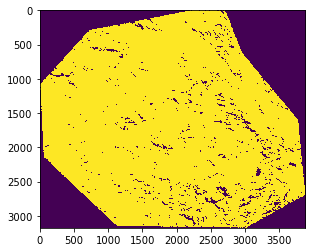

In [10]:
plt.imshow(~common_mask)

In [71]:
cnt = np.ma.masked_equal(ma_stack.count(axis=0), 0)

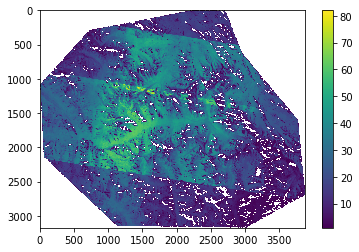

In [72]:
plt.imshow(cnt)
plt.colorbar()

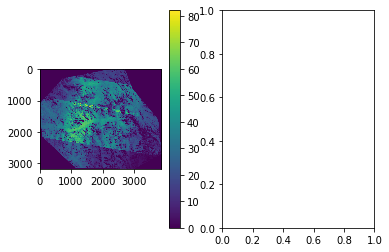

In [57]:
f, axa = plt.subplots(1,2)
m = axa[0].imshow(cnt)
plt.colorbar(m, ax=axa[0])
#m = axa[1].imshow(ma_stack.std(axis=0))
#plt.colorbar(m, ax=axa[1])

### Per-pixel linear regression

github issue: https://github.com/adehecq/ragmac_xdem/issues/8

```
Write a function that takes a stack of DEMs on the same grid (i.e. a 3D masked array) and returns fit parameters of a temporal regression.
Example based on David's code: https://github.com/dshean/pygeotools/blob/9c8d7d5cff5f4fd1c08cf2d46dd1566d229ae9ad/pygeotools/lib/malib.py#L999

Additionally, write a function that takes the fit parameters and returns the elevation of all pixels at any given time within the valid time range.
```


### Prepare test dataset

In [169]:
#ma_stack_test = ma_stack[:, 1000:1032, 1000:1032]
stride = 10
ma_stack_test = ma_stack[:, ::stride, ::stride]

In [170]:
ma_stack_test.shape

(119, 318, 388)

In [171]:
def plot_ma_linreg_3panel(results):
    m, b, m_detr = results
    f, axa = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 3), dpi=150)
    clim_perc = (5, 95)
    _m = axa[0].imshow(m, cmap='RdBu', clim=temporal.calcperc_sym(m, clim_perc))
    f.colorbar(_m, ax=axa[0])
    _m = axa[1].imshow(b, cmap='viridis', clim=temporal.calcperc(b))
    f.colorbar(_m, ax=axa[1])
    _m = axa[2].imshow(m_detr, cmap='inferno', clim=temporal.calcperc(m_detr, (0,95)))
    f.colorbar(_m, ax=axa[2])

    for ax in axa:
        ax.set_xticks(())
        ax.set_yticks(())

In [172]:
def plot_ma_linreg(results):
    m, b, m_detr = results
    f, ax = plt.subplots(dpi=150)
    clim_perc = (5, 95)
    _m = ax.imshow(m, cmap='RdBu', clim=temporal.calcperc_sym(m, clim_perc))
    f.colorbar(_m, ax=ax)
    ax.set_xticks(())
    ax.set_yticks(())

In [173]:
%%time
"""
Modifications to malib.ma_linreg transposed to temporal.py
# use matplitlib.dates.date2num directly to convert time stamps
# use psutils to check for logical cores
# add aux functions from malib.py 
 - mad()
 - checkma()
"""

results = temporal.ma_linreg(ma_stack_test, 
                          dt_list, 
                          n_thresh=3, 
                          model='theilsen', 
                          dt_stack_ptp=None, 
                          min_dt_ptp=None, 
                          smooth=False,
                          rsq=False, 
                          conf_test=False, 
                          parallel=True, 
                          n_cpu=None, 
                          remove_outliers=False)

Excluding pixels with count < 3
Iteration #1
86204 valid pixels with up to 119 timestamps: 2075906 total valid samples
Running in parallel with 15 processes


Fitting temporal trend: 100%|████████████████████████████████████| 86204/86204 [01:20<00:00, 1075.28it/s]


Computing residuals
CPU times: user 21.6 s, sys: 4.69 s, total: 26.3 s
Wall time: 1min 23s


/Users/dshean/sw/miniconda3/envs/ragmac_xdem/lib/python3.9/site-packages/numpy/ma/core.py:4285: RuntimeWarning: invalid value encountered in multiply
  self._data.__imul__(np.where(self._mask, self.dtype.type(1),


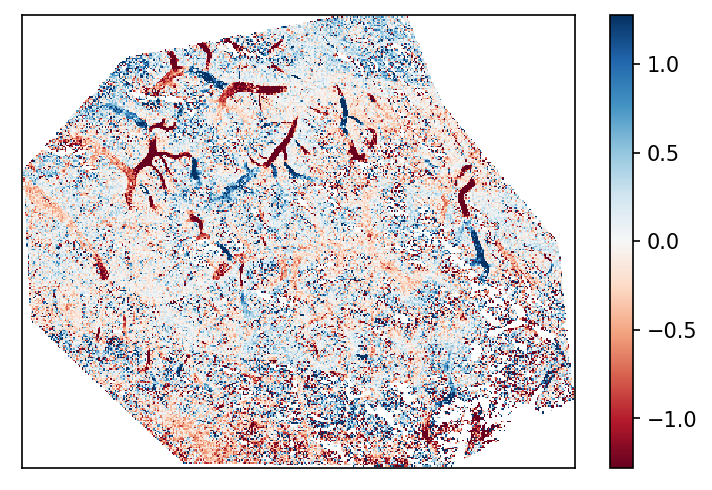

In [174]:
plot_ma_linreg(results)

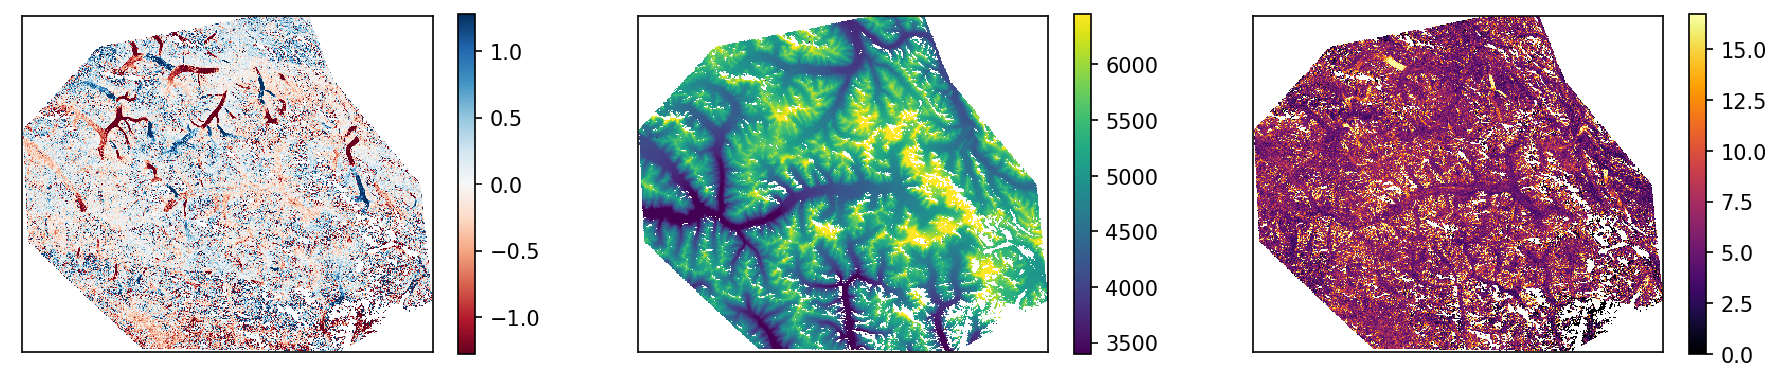

In [175]:
plot_ma_linreg_3panel(results)

## To do
* Filter outliers
* Smoothing
* Add multiprocessing for other robust linear fit appraoches (Romain, Amaury)
* Extrapolate/interpolate to arbitrary dates
* Test for shorter periods between target dates

In [176]:
baltoro_paths = files.get_data_paths("PK_Baltoro")

In [177]:
#dt_list_validation = baltoro_paths['validation_dates']

In [178]:
dt_list_validation = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in baltoro_paths['validation_dates']]
dt_list_validation

[datetime.datetime(2000, 2, 1, 0, 0),
 datetime.datetime(2012, 10, 1, 0, 0),
 datetime.datetime(2019, 10, 1, 0, 0)]

In [179]:
dt_pad = datetime.timedelta(365.25)

In [180]:
dt_pad

datetime.timedelta(days=365, seconds=21600)

In [208]:
valid_dt_idx1 = (dt_list >= dt_list_validation[0] - dt_pad) & (dt_list <= dt_list_validation[1] + dt_pad)

In [209]:
valid_dt_idx1.sum()

81

In [214]:
n_thresh = 5
min_dt_ptp = 365.25 * 5

In [215]:
results1 = temporal.ma_linreg(ma_stack_test[valid_dt_idx1], 
                          dt_list[valid_dt_idx1], 
                          n_thresh=n_thresh, 
                          model='theilsen', 
                          dt_stack_ptp=None, 
                          min_dt_ptp=min_dt_ptp, 
                          smooth=False,
                          rsq=False, 
                          conf_test=False, 
                          parallel=True, 
                          n_cpu=None, 
                          remove_outliers=False)

Excluding pixels with count < 5
Iteration #1
77593 valid pixels with up to 81 timestamps: 1315196 total valid samples
Running in parallel with 15 processes


Fitting temporal trend: 100%|████████████████████████████████████| 77593/77593 [00:44<00:00, 1725.98it/s]


Computing residuals


In [184]:
cnt = np.ma.masked_equal(ma_stack_test[valid_dt_idx1].count(axis=0), 0)

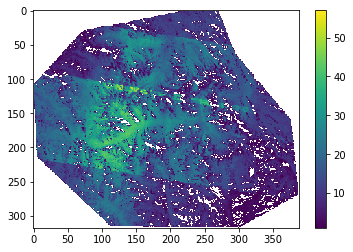

In [185]:
plt.imshow(cnt)
plt.colorbar()

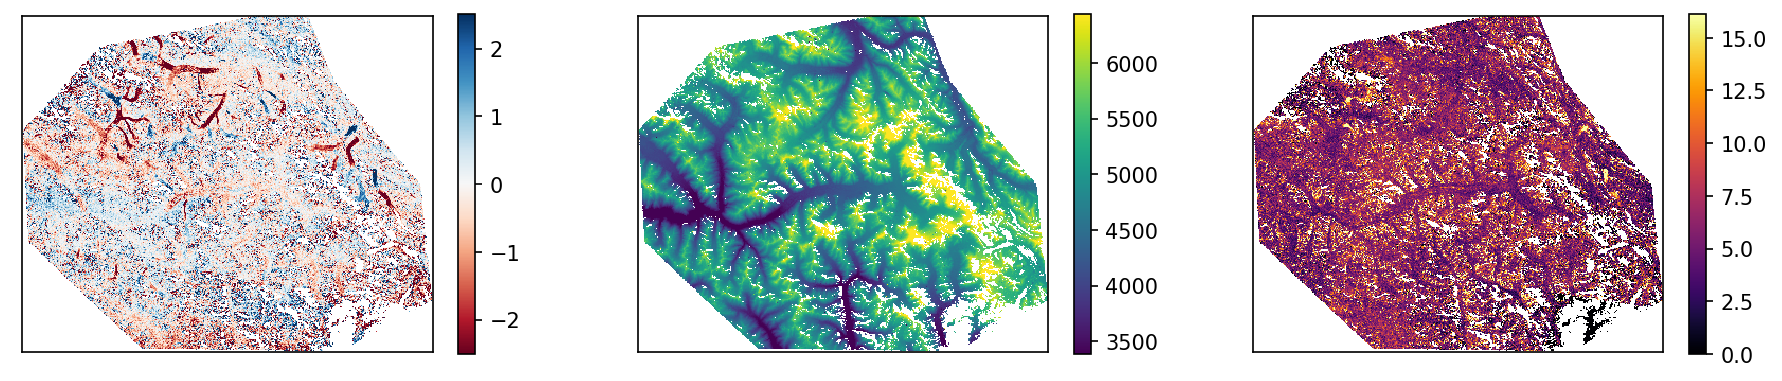

In [186]:
plot_ma_linreg_3panel(results1)

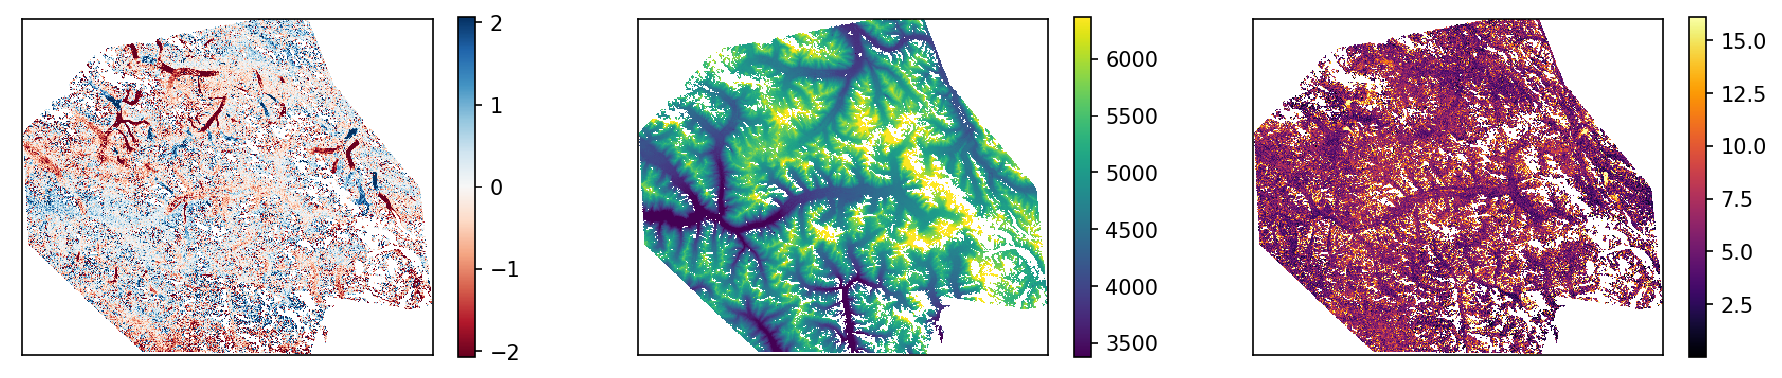

In [211]:
plot_ma_linreg_3panel(results1)

In [217]:
valid_dt_idx2 = (dt_list >= dt_list_validation[1] - dt_pad) & (dt_list <= dt_list_validation[2] + dt_pad)

In [218]:
valid_dt_idx2.sum()

46

In [219]:
results2 = temporal.ma_linreg(ma_stack_test[valid_dt_idx2], 
                          dt_list[valid_dt_idx2], 
                          n_thresh=n_thresh, 
                          model='theilsen', 
                          dt_stack_ptp=None, 
                          min_dt_ptp=min_dt_ptp, 
                          smooth=False,
                          rsq=False, 
                          conf_test=False, 
                          parallel=True, 
                          n_cpu=None, 
                          remove_outliers=False)

Excluding pixels with count < 5
Iteration #1
60468 valid pixels with up to 46 timestamps: 728783 total valid samples
Running in parallel with 15 processes


Fitting temporal trend: 100%|████████████████████████████████████| 60468/60468 [00:23<00:00, 2610.90it/s]


Computing residuals


In [220]:
cnt = np.ma.masked_equal(ma_stack_test[valid_dt_idx2].count(axis=0), 0)

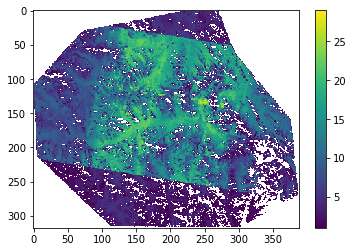

In [221]:
plt.imshow(cnt)
plt.colorbar()

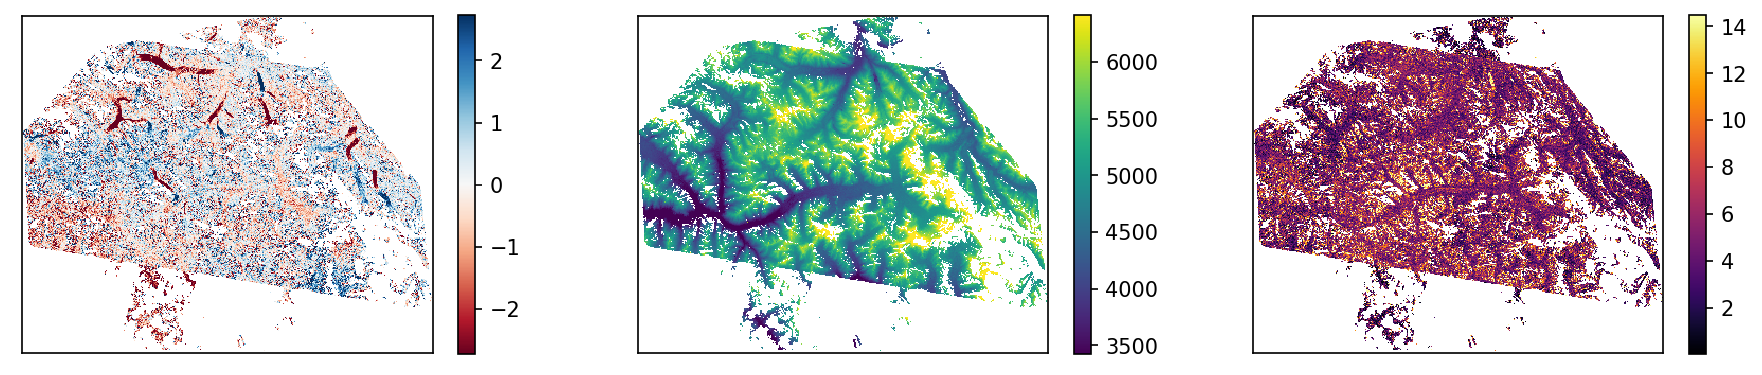

In [222]:
plot_ma_linreg_3panel(results2)

## Load ref DEM

In [96]:
ref_fn = baltoro_paths['raw_data']['ref_dem_path']

In [97]:
ref_src = gu.georaster.Raster(ref_fn)  

In [100]:
ref_src.data.shape

(1, 3176, 3878)

In [101]:
ma_stack.shape

(119, 3176, 3878)

In [104]:
#med = np.ma.median(ma_stack, axis=0)
med = np.ma.median(ma_stack_test, axis=0)

In [103]:
med

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

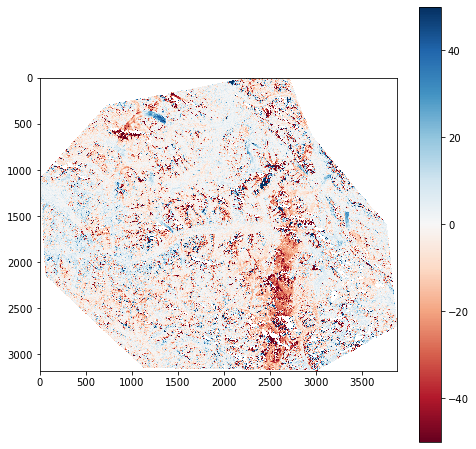

In [114]:
f, ax = plt.subplots(figsize=(8,8))
m = ax.imshow(ref_src.data.squeeze() - med, vmin=-50, vmax=50, cmap='RdBu')
f.colorbar(m, ax=ax)

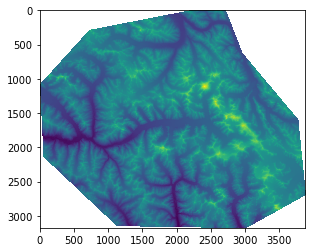

In [116]:
plt.imshow(ref_src.data.squeeze())

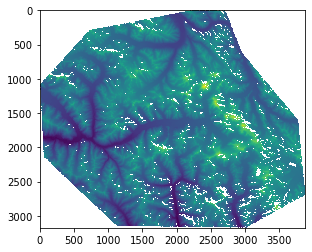

In [117]:
plt.imshow(med)

## Interpolation/extrapolate to validation dates

In [193]:
dt_list_validation

[datetime.datetime(2000, 2, 1, 0, 0),
 datetime.datetime(2012, 10, 1, 0, 0),
 datetime.datetime(2019, 10, 1, 0, 0)]

In [194]:
matplotlib.dates.date2num(dt_list_validation[0])

10988.0

In [195]:
z0 = (results[0]/365.25) * matplotlib.dates.date2num(dt_list_validation[0]) + results[1]
z1 = (results[0]/365.25) * matplotlib.dates.date2num(dt_list_validation[1]) + results[1]
z2 = (results[0]/365.25) * matplotlib.dates.date2num(dt_list_validation[2]) + results[1]

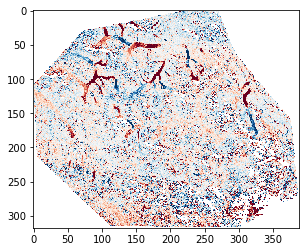

In [196]:
plt.imshow(z1-z0, cmap='RdBu', vmin=-20, vmax=20)

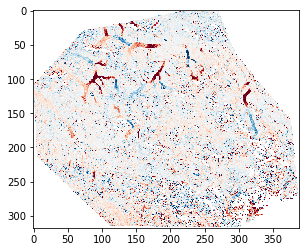

In [197]:
plt.imshow(z2-z1, cmap='RdBu', vmin=-20, vmax=20)

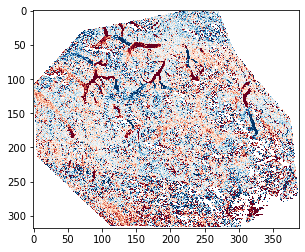

In [198]:
plt.imshow(z2-z0, cmap='RdBu', vmin=-20, vmax=20)

In [199]:
z0 = (results1[0]/365.25) * matplotlib.dates.date2num(dt_list_validation[0]) + results1[1]
z1 = (results1[0]/365.25) * matplotlib.dates.date2num(dt_list_validation[1]) + results1[1]

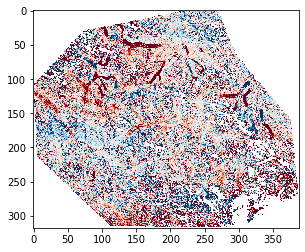

In [200]:
plt.imshow(z1-z0, cmap='RdBu', vmin=-20, vmax=20)

In [201]:
z1 = (results2[0]/365.25) * matplotlib.dates.date2num(dt_list_validation[1]) + results2[1]
z2 = (results2[0]/365.25) * matplotlib.dates.date2num(dt_list_validation[2]) + results2[1]

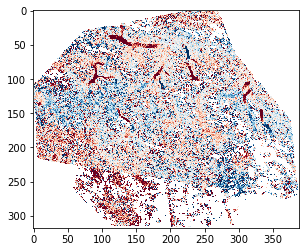

In [202]:
plt.imshow(z2-z1, cmap='RdBu', vmin=-20, vmax=20)

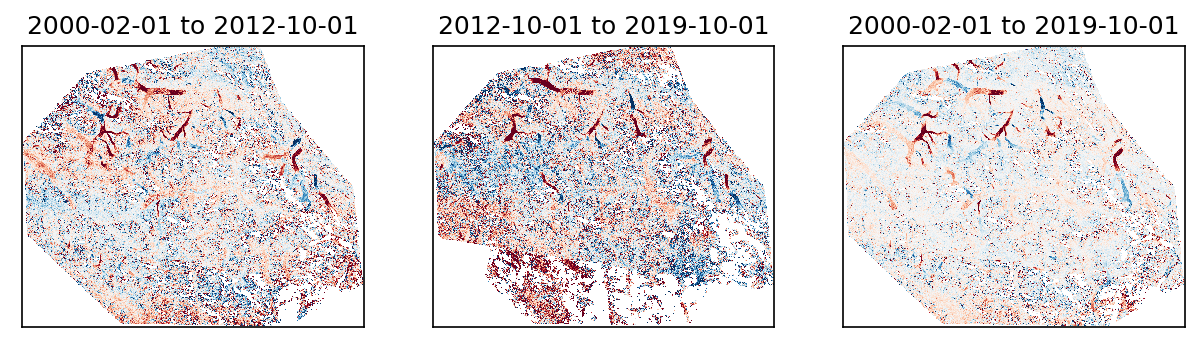

In [204]:
f, axa = plt.subplots(1,3, figsize=(10,4), dpi=150)
clim = (-3, 3)
axa[0].imshow(results1[0], vmin=clim[0], vmax=clim[1], cmap='RdBu')
axa[0].set_title(f'{dt_list_validation[0].date()} to {dt_list_validation[1].date()}')
axa[1].imshow(results2[0], vmin=clim[0], vmax=clim[1], cmap='RdBu')
axa[1].set_title(f'{dt_list_validation[1].date()} to {dt_list_validation[2].date()}')
axa[2].imshow(results[0], vmin=clim[0], vmax=clim[1], cmap='RdBu')
axa[2].set_title(f'{dt_list_validation[0].date()} to {dt_list_validation[2].date()}')
for ax in axa:
    ax.set_xticks(())
    ax.set_yticks(())